# **COCA Coronary Calcium and Chest CT - Exploratory Data Analysis**

## Sources:

Data - https://stanfordaimi.azurewebsites.net/datasets/e8ca74dc-8dd4-4340-815a-60b41f6cb2aa

# Import Dependencies

In [21]:
# File Support
try: 
    import pydicom as dcm
except:
    # Use try except for Google Colab
    !pip install pydicom
from pydicom.data import get_testdata_files
import xml
import xml.etree.ElementTree as ET 

# Base
import numpy as np
import pandas as pd
import random

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns
from PIL import Image

# SK-learn
import sklearn

# Files
import os
from os.path import join, split
from glob import glob

# Torch
import torch
from torch import nn
from torch.nn import Conv2d
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

# Config

In [22]:
class CFG:
    random_seed = 42
    gated = True
    path = "Coronary CT Data\Gated_release_final" if gated else "Coronary CT Data/deidentified_nongated"

In [23]:
import warnings
warnings.filterwarnings("ignore")

## Reproducibility

In [24]:
def set_seed(seed=CFG.random_seed):
    print(f"Seed: {seed}")
    random.seed(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)

set_seed()

Seed: 42


# Helper Functions

In [25]:
def read_dicom(path):
    arr = dcm.dcmread(path).pixel_array
    arr = (arr-arr.min())/(arr.max()-arr.min())
    return arr

In [26]:
def parseXML(xmlfile): 
    # create element tree object 
    tree = ET.parse(xmlfile) 

    all_images = []

    images = tree.find("dict").find("array")
    images = images.findall("dict")

    # Images
    for image in images:
        image_data = {}
        arr = [i.text for i in image if i.tag not in ["array", "dict"]]
        
        for i in range(len(arr)//2):
            image_data[arr[2*i]] = arr[2*i+1]

        image_data['ROIs'] = []

        # ROI
        all_roi = image.find("array").findall('dict')
        for roi in all_roi:
            roi_data = {}
            arr = [i.text for i in roi if i.tag not in ["array", "dict"]]
        
            for i in range(len(arr)//2):
                roi_data[arr[2*i]] = arr[2*i+1]

            all_points = roi.findall('array')
            roi_data['point_mm'] = [i.text for i in all_points[0].findall("string")]
            roi_data['point_px'] = [i.text for i in all_points[1].findall("string")]
            
            image_data['ROIs'].append(roi_data)
        all_images.append(image_data)

    return all_images

In [27]:
class ChestCT:
    def __init__(self, xmlData : dict): # xmlData is 
        self.image_idx = xmlData['ImageIndex']
        path = join(CFG.path,f"patient\\{self.image_idx}")
        
        self.all_paths = glob(f"{path}/**/**.dcm") # Returns all dicom file paths for a specific patient
        
            
    def __len__(self):
        return len(self.all_paths)
    
    def display(self):
        pass

In [28]:
def create_segments(image_array, points):
    polygon = Polygon(points, closed=True, edgecolor='r', facecolor='r')
    polygon_indices = np.array(points)
    polygon_indices[:, 0] = np.clip(polygon_indices[:, 0], 0, 511)
    polygon_indices[:, 1] = np.clip(polygon_indices[:, 1], 0, 511)
    image_array[polygon_indices[:, 1], polygon_indices[:, 0]] = 1
    polygon_path = Path(polygon_indices)
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    points = np.column_stack((x.flatten(), y.flatten()))
    mask = polygon_path.contains_points(points).reshape(512, 512)
    image_array[mask] = 1

    return image_array

In [29]:
def plot_image(img_path):
    img  = dcm.dcmread(img_path).pixel_array
    img_idx = str(int(split(img_path)[-1][8:-4]))
    
    patient_id = img_path.split("\\")[-3]
    label_path = join(CFG.path, f'calcium_xml\{patient_id}.xml')

    print(f"Patient ID: {patient_id}")
    print(f"Image ID: {img_idx}")

    try:
        labels = parseXML(label_path)
        indexes = [i['ImageIndex'] for i in labels]
    except:
        indexes = []

    img_label = np.zeros((512,512))
    if img_idx in indexes:
        ROIs = labels[indexes.index(img_idx)]['ROIs']
        for roi in ROIs:
            points = (roi['point_px'])
            points = [(int(round(float(eval(point)[0]), 0)), int(round(float(eval(point)[1]), 0))) for point in points]
            if points:
                img_label = create_segments(img_label, points)
    
    
    norm = Normalize(vmin=0, vmax=255)
    overlay = np.stack((img*0.05,)*3, axis=2)
    overlay = norm(overlay)
    overlay[:,:,0] = overlay[:,:,0] + img_label

    fig, ax = plt.subplots(1,3, figsize=(10,10))
    for i in range(3):
        ax[i].spines['top'].set_visible(False)
        ax[i].spines['right'].set_visible(False)
        ax[i].spines['bottom'].set_visible(False)
        ax[i].spines['left'].set_visible(False)
        ax[i].get_xaxis().set_ticks([])
        ax[i].get_yaxis().set_ticks([])

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("Image", fontsize=10)
    ax[1].imshow(img_label, cmap="inferno")
    ax[1].set_title("Label", fontsize=10)
    ax[2].imshow(overlay)
    ax[2].set_title("Overlay", fontsize=10)
    plt.show()
    
    

# Preview Data

In [30]:
image_paths = glob(f"{CFG.path}\\**\\**\\**\\*.dcm")
label_paths = glob(f"{CFG.path}\\patient\\**")
print(f"{len(image_paths)} images")
print(f"{len(label_paths)} patients")

40113 images
787 patients


## Plot Images

Patient ID: 226
Image ID: 12


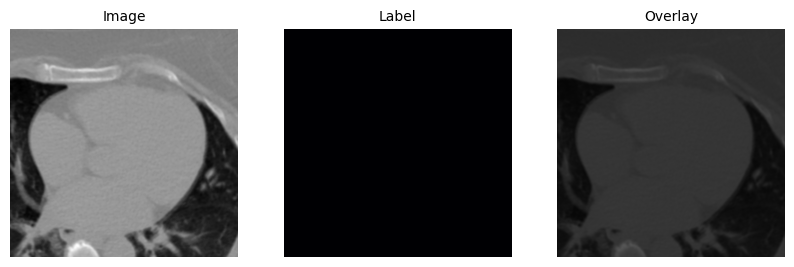

Patient ID: 127
Image ID: 40


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


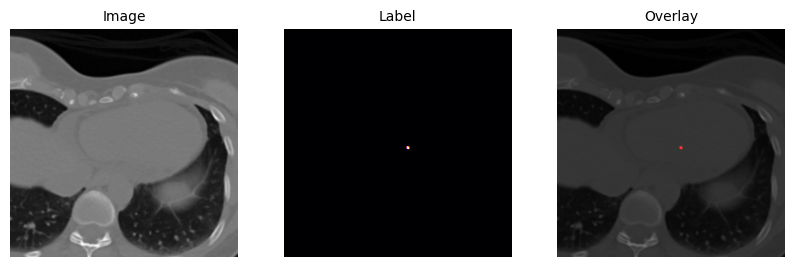

Patient ID: 417
Image ID: 19


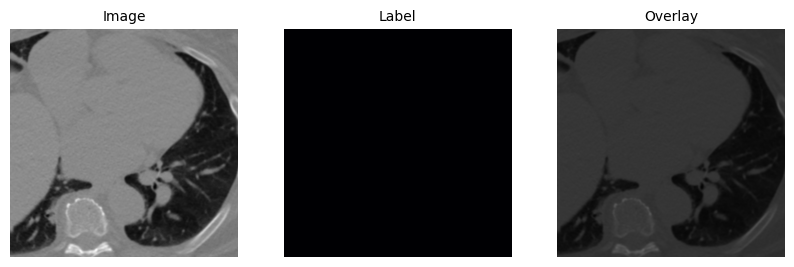

In [31]:
nSamples = 3
for i in range(nSamples):
    idx = random.randint(0,len(image_paths))
    plot_image(image_paths[idx])

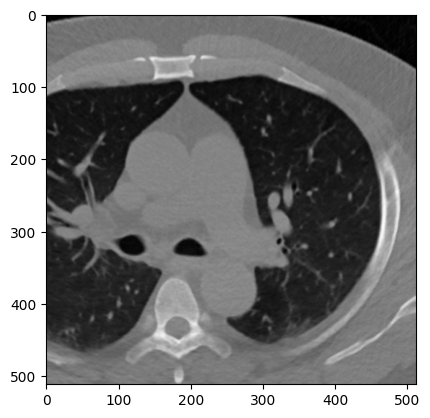

In [32]:
arr = read_dicom(image_paths[0])
plt.imshow(arr, cmap='gray')

## Check Uniformity

In [33]:
orientations = set({})
all_labels = glob(f"{CFG.path}/**/**.xml")
for xml_file in all_labels:
    labels = parseXML(xml_file)
    for label in labels:
        paths = ChestCT(label).all_paths
        for i in paths:
            scan = dcm.dcmread(i)
            orientation = [str(int(i)) for i in scan["ImageOrientationPatient"].value]
            orientations.add("".join(orientation))

f"{len(orientations)} unique orientation(s)"

'1 unique orientation(s)'

**All Images Have Same Orientation - No Transformation Needed**

# Create Dataset

In [34]:
class CTScanDataset(Dataset):
    def __init__(self, data_dir):
        super().__init__()
        self.patients_list = glob(f"{data_dir}\patient\*")
        self.all_images = glob(f"{data_dir}\patient\*\*\*.dcm")

        self.blanks = 0

    def __len__(self):
        return len(self.all_images)
    
    def __getitem__(self, idx): # Return tuple (x, y)
        img_path = self.all_images[idx]

        img  = dcm.dcmread(img_path).pixel_array
        img_idx = str(int(split(img_path)[-1][8:-4]))
        
        patient_id = img_path.split("\\")[-3]
        label_path = join(CFG.path, f'calcium_xml\{patient_id}.xml')

        try:
            labels = parseXML(label_path)
            indexes = [i['ImageIndex'] for i in labels]
        except:
            indexes = []

        img_label = np.zeros((512,512))
        if img_idx in indexes:
            ROIs = labels[indexes.index(img_idx)]['ROIs']
            for roi in ROIs:
                points = (roi['point_px'])
                points = [(int(round(float(eval(point)[0]), 0)), int(round(float(eval(point)[1]), 0))) for point in points]
                if points:
                    img_label = create_segments(img_label, points)

        return img, img_label
        


In [35]:
data = CTScanDataset("Coronary CT Data\Gated_release_final")
len(data)

40113

# Save Dataset

In [36]:
train_data, valid_data = random_split(data, [0.7, 0.3])

In [37]:
print(f"Train: {len(train_data)}")
print(f"Validation: {len(valid_data)}")

Train: 28080
Validation: 12033


In [38]:
torch.save(train_data, "Datasets/train.pt")
torch.save(valid_data, "Datasets/test.pt")